In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, models
from torchvision.transforms import v2

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
ps_battles_dir = os.getenv("PS_BATTLES_DIR")
ci_fake_dir = os.getenv("CI_FAKE_DIR")

In [3]:
train_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet normalization
])

test_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet normalization
])

data_transforms = {
    'train': train_transforms,
    'test': test_transforms
}

In [4]:
ci_fake_dataset = {x: datasets.ImageFolder(os.path.join(ci_fake_dir, x), data_transforms[x]) for x in ['train', 'test']}
ci_fake_dataloader = {x: DataLoader(ci_fake_dataset[x], batch_size=64, shuffle=True) for x in ['train', 'test']}

print('Train dataset size:', len(ci_fake_dataset['train']))
print('Test dataset size:', len(ci_fake_dataset['test']))

Train dataset size: 56
Test dataset size: 28


In [5]:
ci_fake_classes = ci_fake_dataset['train'].classes
ci_fake_classes

['fake', 'real']

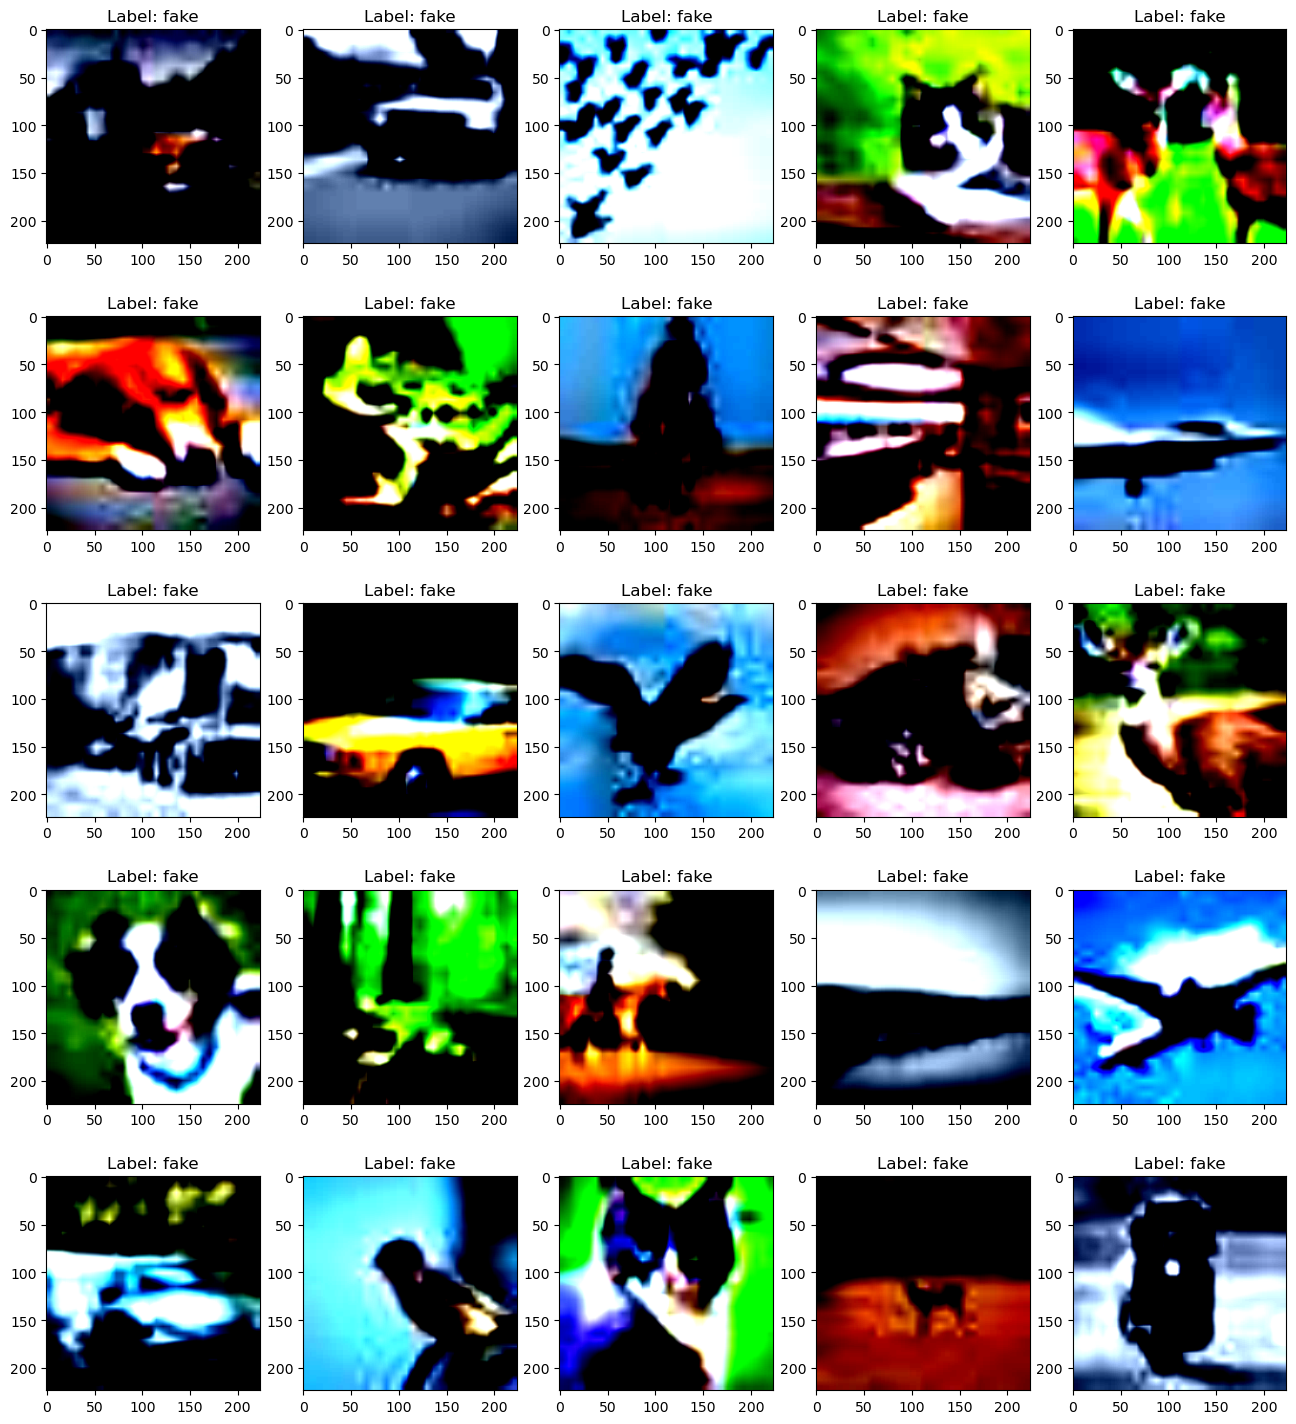

In [6]:
N_IMAGES = 25
plt.figure(figsize=(16, 18))
for i in range(N_IMAGES):
  img = ci_fake_dataset['train'][i][0].permute(1, 2, 0)
  img = torch.clamp(img, 0, 1)
  label = ci_fake_dataset['train'][i][1]
  plt.subplot(5,5,i+1), plt.imshow(img), plt.title(f"Label: {ci_fake_classes[label]}")

### Models

In [7]:
model = models.resnet50(weights='IMAGENET1K_V2')
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, len(ci_fake_classes))
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
def fit(model, train_dataloader, test_dataloader, epochs, optimizer, loss_function):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            y_pred = model.forward(X_batch)
            loss = loss_function(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_dataloader))

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_dataloader:
                y_pred = model.forward(X_batch)
                loss = loss_function(y_pred, y_batch)
                test_loss += loss.item()
        test_losses.append(test_loss / len(test_dataloader))

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")
        
    return train_losses, test_losses

def predict(model, dataloader):
    all_outputs = []
    for X_batch, _ in dataloader:
        outputs = model.forward(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        all_outputs.extend(predicted.numpy())
    return np.array(all_outputs)

In [9]:
def verify_parameters(y_test, y_pred_tab, parameters):
    results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    for i in range(len(parameters)):
        accuracy_score_test = accuracy_score(y_test, y_pred_tab[i])
        precision_score_test = precision_score(y_test, y_pred_tab[i], average='macro')
        recall_score_test = recall_score(y_test, y_pred_tab[i], average='macro')
        f1_score_test = f1_score(y_test, y_pred_tab[i], average='macro')
        results.loc[str(parameters[i])] = [accuracy_score_test, precision_score_test, recall_score_test, f1_score_test]

    return results

In [13]:
model.fit = fit(model, ci_fake_dataloader['train'], ci_fake_dataloader['test'], 100, optimizer, loss)
predictions = predict(model, ci_fake_dataloader['test'])

Epoch 1/100 - Train Loss: 0.5167, Test Loss: 0.5683
Epoch 2/100 - Train Loss: 0.4994, Test Loss: 0.5618
Epoch 3/100 - Train Loss: 0.4577, Test Loss: 0.5600
Epoch 4/100 - Train Loss: 0.4353, Test Loss: 0.5583
Epoch 5/100 - Train Loss: 0.4291, Test Loss: 0.5561
Epoch 6/100 - Train Loss: 0.3979, Test Loss: 0.5554
Epoch 7/100 - Train Loss: 0.3788, Test Loss: 0.5579
Epoch 8/100 - Train Loss: 0.3487, Test Loss: 0.5600
Epoch 9/100 - Train Loss: 0.3426, Test Loss: 0.5619
Epoch 10/100 - Train Loss: 0.3228, Test Loss: 0.5635
Epoch 11/100 - Train Loss: 0.2877, Test Loss: 0.5609
Epoch 12/100 - Train Loss: 0.2961, Test Loss: 0.5557
Epoch 13/100 - Train Loss: 0.2716, Test Loss: 0.5494


KeyboardInterrupt: 

In [ ]:
df_scores = verify_parameters(ci_fake_dataset['test'].targets, [predictions], ['ResNet50'])
df_scores

,Accuracy,Precision,Recall,F1 Score
ResNet50,0.428571,0.427083,0.428571,0.425641
